In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import ode
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math, cmath
import time

In [2]:
import jax.tools.colab_tpu
import jax.numpy as jnp
from jax import jit, grad
#jax.tools.colab_tpu.setup_tpu()

In [3]:
!cp drive/MyDrive/jmp.py .
import numpy as np
from jmp import Params, Operators, StateVector
from scipy.integrate import solve_ivp
from scipy.integrate import ode
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math, cmath

In [4]:
#@jax.jit
def normalize(x):
    return x / jnp.linalg.norm(x)

#@jax.jit
def density_mat(v, vectorize=False):
    #v = jnp.array([1,0])
    v_norm = v/jnp.linalg.norm(v)
    psi_v = v_norm.copy().reshape(-1,1)
    rho_v = jnp.dot(psi_v, psi_v.T)
    psi_v = rho_v.T.copy().reshape(-1,1)
    if vectorize:
        return psi_v
    else:
        return rho_v

#@jax.jit
def mat_mul(a,b, vectorize=True):
    # Only for square matrices
    a=a.reshape(int((a.size)**0.5),int((a.size)**0.5))
    b=b.reshape(int((b.size)**0.5),int((b.size)**0.5))
    c=jnp.dot(a,b)
    if vectorize:
        c=c.reshape(c.size,)
    return c

h_bar = 1

def coeff(n):
    c = [(1/math.factorial(i)) for i in list(reversed(range(n)))]
    return jnp.array(c)

In [5]:
q_ndim = 2
c_ndim = 50
g = 0.0486 * 2*np.pi
alpha = 2
K=0.0014 * 2*np.pi # kappa
w_c = 7.415 * 2*np.pi
w_q = 4.4619 * 2*np.pi
w_d_qb0 = 7.4156 * 2*np.pi
w_d_qb1 = 7.41439 * 2*np.pi
w_d = w_d_qb0
#A_d = 0.011 *2*np.pi
A_d = 0.005

params = Params(q_ndim, c_ndim, g, alpha, K, w_q, w_c, w_d, A_d)
op = Operators(params)
st = StateVector(params)

H_L = w_q * jnp.kron(jnp.dot(op.q_d , op.q), op.I_c) + g * (jnp.kron(op.q_d,op.a) + jnp.kron(op.q,op.a_d)) \
            + w_c * jnp.kron(op.I_q,jnp.dot(op.a_d, op.a)) #H_lossless
psi_0_q = normalize(jnp.array([1,0], dtype=complex)).reshape(params.q_ndim, -1)
#psi_0_c = st.coherent()
psi_0_c = normalize(st.fock(0)).reshape(params.c_ndim, -1)
psi_0 = jnp.kron(psi_0_q, psi_0_c).reshape(params.ndim,-1)
rho_0, t_0 = (jnp.dot(psi_0, psi_0.T)).reshape(params.ndim**2,), 0

In [6]:
#@jax.jit
def H_l(t):
    return w_q * jnp.kron(jnp.dot(op.q_d, op.q), op.I_c) + g * (jnp.kron(op.q_d,op.a) + jnp.kron(op.q,op.a_d)) \
        + w_c * jnp.kron(op.I_q,jnp.dot(op.a_d, op.a)) \
            - 1j*(jnp.kron(op.I_q, A_d * jnp.sin(w_d * t) * (op.a - op.a_d)))

In [7]:
#@jax.jit
def f(t, rho):
                        
    func = (1j/h_bar)*(mat_mul(rho,H_l(t))-mat_mul(H_l(t),rho)) \
                - (K/2)*(mat_mul((jnp.kron(op.I_q,jnp.dot(op.a_d, op.a))),rho) + mat_mul(rho, jnp.kron(op.I_q,jnp.dot(op.a_d, op.a))) \
                    - 2*(mat_mul(jnp.kron(op.I_q,op.a), mat_mul(rho, jnp.kron(op.I_q,op.a_d)))))
    return func

In [8]:
# Uses numpy and NOT JAX

def grid(matrix, m, n): #creates matrix grids out of the "matrix" : m pieces along rows and n pieces along columns
    temp = np.zeros((m,n, int(matrix.shape[0]/m) , int(matrix.shape[1]/n)), dtype=complex)
    for i in range(m):
        for j in range(n):
            for k in range(int(matrix.shape[0]/m)):
                for l in range(int(matrix.shape[1]/n)):
                    temp[i,j,k,l] = complex(np.hsplit(np.vsplit(matrix, m)[i] , n)[j][k][l])

    return temp

def red_state_q(state): #traces out cavity system and returns the qubit system density matrix
  red_state = np.zeros((params.q_ndim, params.q_ndim), dtype=complex)
  m = grid(state.reshape((params.ndim, params.ndim)),params.c_ndim, params.c_ndim)
  c_bases = [np.eye(1,params.c_ndim,index) for index in range(params.c_ndim)]

  for i in range(params.q_ndim):
      for j in range(params.q_ndim):
          temp = np.zeros((params.c_ndim, params.c_ndim), dtype=complex)
          for k in range(params.c_ndim):
              for l in range(params.c_ndim):
                  temp[k,l] = m[k,l][i,j]
          for b in c_bases:
              red_state[i,j] += np.dot(np.dot(b, temp),b.T)
  return red_state

def red_state_c(state): #traces out qubit system and returns the cavity system density matrix
  red_state = np.zeros((params.c_ndim, params.c_ndim), dtype=complex)
  m = grid(state.reshape((params.ndim, params.ndim)),params.q_ndim, params.q_ndim)
  q_bases = [np.eye(1,params.q_ndim,index) for index in range(params.q_ndim)]

  for i in range(params.c_ndim):
      for j in range(params.c_ndim):
          temp = np.zeros((params.q_ndim, params.q_ndim), dtype=complex)
          for k in range(params.q_ndim):
              for l in range(params.q_ndim):
                  temp[k,l] = m[k,l][i,j]
          for b in q_bases:
              red_state[i,j] += np.dot(np.dot(b, temp),b.T)
  return red_state

def pop(state, n):
    red_state = red_state_c(state)
    return abs(jnp.dot(jnp.dot(st.fock(n), red_state), st.fock(n).T))

def fid(state): #state = density matrix
  return jnp.sqrt((abs(jnp.dot(jnp.dot(psi_0_q.T , state),psi_0_q.T))))

In [9]:
# mode : (m1, m2) : 0 - t, 1 - x, 2 - p, 3 - n 
# So, mode = (1,0) will obtain results and plot x vs t 
# mode = (y,x)

def result(mode, t1, dt, method, output = 'plot'):
    psi_0 = np.kron(psi_0_q, psi_0_c).reshape(params.ndim,-1)
    rho_0, t_0 = jnp.dot(psi_0, psi_0.T).reshape(params.ndim**2,), 0

    printtimes=list( np.linspace(0, 0.95*t1, 10) )
    
    if method == 'ode':
        def f(t, rho):
            #def H_l(t):
                #return w_q * np.kron(jnp.dot(op.q_d, op.q), op.I_c) + g * (np.kron(op.q_d,op.a) + np.kron(op.q,op.a_d)) \
                    #+ w_c * np.kron(op.I_q,jnp.dot(op.a_d, op.a)) \
                        #- 1j*(np.kron(op.I_q, A_d * np.sin(w_d * t) * (op.a - op.a_d)))
                        
            func = (1j/h_bar)*(mat_mul(rho,H_l(t))-mat_mul(H_l(t),rho)) \
                - (K/2)*(mat_mul((jnp.kron(op.I_q,jnp.dot(op.a_d, op.a))),rho) + mat_mul(rho, jnp.kron(op.I_q,jnp.dot(op.a_d, op.a))) \
                    - 2*(mat_mul(jnp.kron(op.I_q,op.a), mat_mul(rho, jnp.kron(op.I_q,op.a_d)))))
            return jnp.array(func)

        result = ode(f).set_integrator('zvode', method='bdf')
        result.set_initial_value(rho_0, t_0)
        xx=[]
        yy=[]

        while result.successful() and result.t < t1:
            if (printtimes and (result.t>printtimes[0])):
              printtimes.pop(0)
              print( np.round(result.t*100 / t1,0), end='% '  )
              if not printtimes:
                print()
            state=jnp.array(result.integrate(result.t+dt).reshape(params.ndim, params.ndim))
            ops = [result.t + dt, jnp.dot(jnp.kron(op.x,op.I_c), state).trace(), jnp.dot(jnp.kron(op.p,op.I_c), state).trace() ,jnp.dot(jnp.kron(op.I_q, op.n), state).trace()]
            xx.append(ops[mode[1]])
            yy.append(ops[mode[0]])

        labels = ['t', r'$<X>$', r'$<P>$', r'$<N>$']
        
        if output == 'values':
          return xx,yy
        
        if output == 'state':
          return state

        if output == 'plot':
          plt.plot(xx,yy)
          plt.title("Method : ODE"+str(vars(params)))
          plt.xlabel(labels[mode[1]])
          plt.ylabel(labels[mode[0]])
          plt.show()

    elif method == 'num':
        n_z=10
        t=0
        #rho_0= rho_0.reshape(params.ndim,params.ndim)

        def f(rho, t):
            

            func = (1j/h_bar)*(mat_mul(rho,H_l(t))-mat_mul(H_l(t),rho)) \
                - (K/2)*(mat_mul((jnp.kron(op.I_q,jnp.dot(op.a_d, op.a))),rho) + mat_mul(rho, jnp.kron(op.I_q,jnp.dot(op.a_d, op.a))) \
                    - 2*(mat_mul(jnp.kron(op.I_q,op.a), mat_mul(rho, jnp.kron(op.I_q,op.a_d)))))
            return jnp.array(func)
        
        z=jnp.roots(coeff(n_z))

        xx = []
        yy = []
        rho1 = rho_0
        #rho2 = rho_0
        t_0 = time.time()
        for j in range(int(t1//dt)+1):
            if (printtimes and (j*dt>printtimes[0])):
              printtimes.pop(0)
              print( np.round(j*dt*100 / t1,0), end='% '  )
              if not printtimes:
                print()
            #rho1 = rho2 ??
            for i in range(n_z-1):
                rho1 = rho1 - (dt/z[i])*f(rho1, j*dt)
            state = rho1.reshape(params.ndim, params.ndim)
            #ops = [j*t + dt, jnp.dot(jnp.kron(op.x,op.I_c),state).trace(), jnp.dot(np.kron(op.p,op.I_c),state).trace() ,jnp.dot(np.kron((op.q_d)@(op.q),op.I_c),state).trace()]
            ops = [j*dt, jnp.dot(jnp.kron(op.x,op.I_c), state).trace(), jnp.dot(jnp.kron(op.p,op.I_c), state).trace() ,jnp.dot(jnp.kron(op.I_q, op.n), state).trace()]
            labels = ['t', r'$<X>$', r'$<P>$', r'$<N>$'] 
            xx.append(ops[mode[1]])
            #yy.append(ops[mode[0]])
            yy.append(float(abs(jnp.dot(jnp.dot(jnp.array([1,0], dtype=complex).reshape((2,1)).T, red_state_q(state)), jnp.array([1,0], dtype=complex).reshape((2,1))))))
            #rho2 = rho1 ??
        t_1 = time.time()
        print("computation time =", np.round(t_1-t_0,1)," s")
        
        labels = ['t', r'$<X>$', r'$<P>$', r'$<N>$']
        
        if output == 'state':
          return state

        if output == 'values':
          return xx, yy

        if output == 'plot':
          plt.plot(xx,yy)
          #plt.title("Method : Numerical"+str(vars(params)))
          #plt.title('Revival of photons')
          plt.xlabel(labels[mode[1]])
          plt.ylabel(labels[mode[0]])
          plt.legend(['|0>', '|1>'])
          plt. savefig('xy.jpg', dpi=330)
          plt.show()

In [ ]:
result((3,0), 10, 1, method = 'num', output = 'plot')

In [ ]:
from google.colab import files
files.download('xy.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.plot(x,np.array(y3) - np.array(y2) )
#plt.plot(x,y2)
#plt.plot(x,y3)
plt.show()

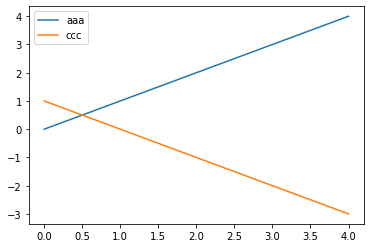

In [ ]:
a = range(5)
b= range(5)
c = [1-i for i in a]

plt.plot(b,a)
plt.plot(b,c)
plt.legend(['aaa','ccc'])
plt.show()

In [ ]:
x = range(params.c_ndim)
state = result((3,0), 50, 0.01, method = 'ode', output = 'state')
y = [pop(state,i) for i in x]

plt.scatter(x,y)

KeyboardInterrupt: ignored

In [ ]:
y

[DeviceArray(1., dtype=float32),
 DeviceArray(2.9329248e-09, dtype=float32),
 DeviceArray(4.301201e-18, dtype=float32),
 DeviceArray(4.7148787e-27, dtype=float32),
 DeviceArray(1.3297318e-32, dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32)]